In [1]:
#. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/kaggle/user_behavior_dataset.csv')

Let's perform predictive churn modeling

We’ll use the User Behavior Class column as a proxy for churn:

Users with Behavior Class ≤ 2 = “Likely Churned”

Users with Behavior Class ≥ 3 = “Active/Retained”

We’ll build a simple classification model (Logistic Regression or Random Forest) to predict churn based on app usage, data usage, battery drain, etc.

In [4]:
# Rename columns for easier coding
df.columns = [
    'user_id', 'device_model', 'os', 'app_usage_min', 'screen_on_hr',
    'battery_mAh', 'num_apps', 'data_mb', 'age', 'gender', 'behavior_class'
]

In [5]:
# Step 1: Define Churn Label
# Make a copy of the data
df_model = df.copy()

# Create churn column (1 = churn, 0 = active)
df_model['churn'] = (df_model['behavior_class'] <= 2).astype(int)
df_model[['behavior_class', 'churn']].head()

,behavior_class,churn
0,4,0
1,3,0
2,2,1
3,3,0
4,3,0


In [7]:
#Step 2: Feature Engineering
#We’ll encode categorical columns and select numeric ones for modeling.
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
le_os = LabelEncoder()
le_gender = LabelEncoder()

df_model['os_enc'] = le_os.fit_transform(df_model['os'])
df_model['gender_enc'] = le_gender.fit_transform(df_model['gender'])

# Select features
features = [
    'app_usage_min', 'screen_on_hr',
    'battery_mAh', 'num_apps',
    'data_mb', 'age', 'os_enc', 'gender_enc'
]

X = df_model[features]
y = df_model['churn']

In [8]:
#Step 3: Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
#Step 4: Train a Model (Random Forest)
from sklearn.ensemble import RandomForestClassifier

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

In [10]:
#Step 5: Evaluate Model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      1.00      1.00        56

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140

ROC AUC: 1.0


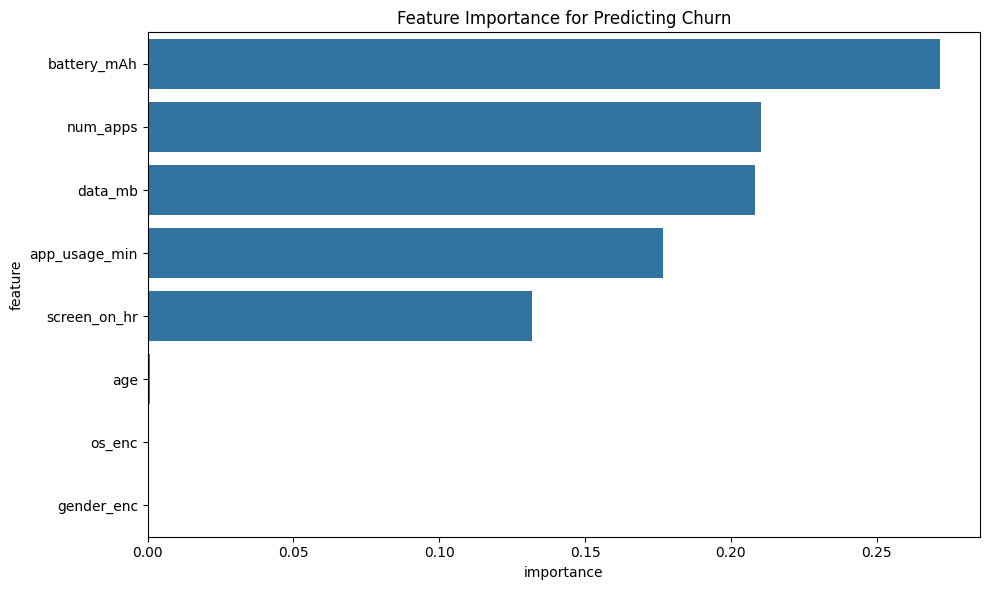

In [11]:
#Step 6: Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
feat_imp = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp, x='importance', y='feature')
plt.title("Feature Importance for Predicting Churn")
plt.tight_layout()
plt.savefig("churn_feature_importance.png")
plt.show()

Let’s build a full churn modeling pipeline with hyperparameter tuning + SHAP explainability.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Create churn label
# --------------------------
df_model = df.copy()
df_model['churn'] = (df_model['behavior_class'] <= 2).astype(int)

# Encode categorical
from sklearn.preprocessing import LabelEncoder
le_os = LabelEncoder()
le_gender = LabelEncoder()
df_model['os_enc'] = le_os.fit_transform(df_model['os'])
df_model['gender_enc'] = le_gender.fit_transform(df_model['gender'])

# Features and labels
features = [
    'app_usage_min', 'screen_on_hr',
    'battery_mAh', 'num_apps',
    'data_mb', 'age', 'os_enc', 'gender_enc'
]
X = df_model[features]
y = df_model['churn']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------
# 2. Pipeline
# --------------------------
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

# --------------------------
# 3. Hyperparameter Tuning
# --------------------------
param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

search = RandomizedSearchCV(
    pipe, param_distributions=param_dist,
    n_iter=20, scoring='roc_auc', cv=3,
    verbose=1, random_state=42, n_jobs=-1
)
search.fit(X_train, y_train)

best_model = search.best_estimator_
print("Best Params:", search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 'log2', 'model__max_depth': 20}


In [ ]:
# --------------------------
# 4. Evaluation
# --------------------------
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

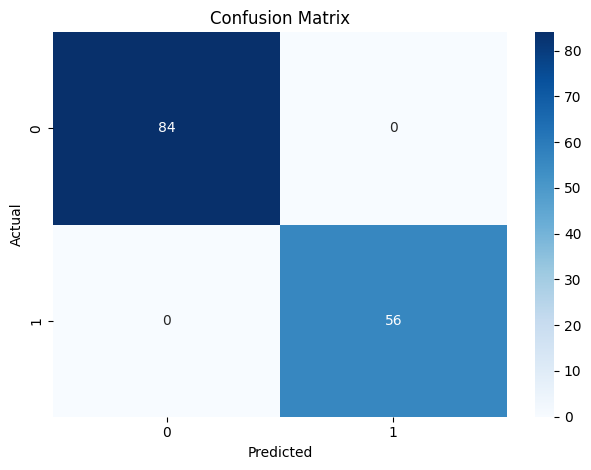

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("churn_confusion_matrix.png")
plt.show()

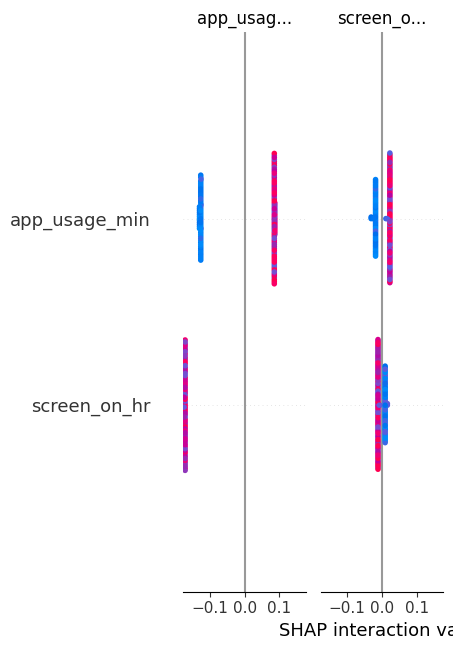

In [43]:
# --------------------------
# 5. SHAP Explainability
# --------------------------
explainer = shap.TreeExplainer(best_model.named_steps['model'])
X_test_scaled = best_model.named_steps['scaler'].transform(X_test) # Scale X_test
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features) # Convert to DataFrame with feature names
shap_values = explainer.shap_values(X_test_scaled_df) # Calculate SHAP values on scaled DataFrame

# Summary plot
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("churn_shap_summary.png")
plt.show()

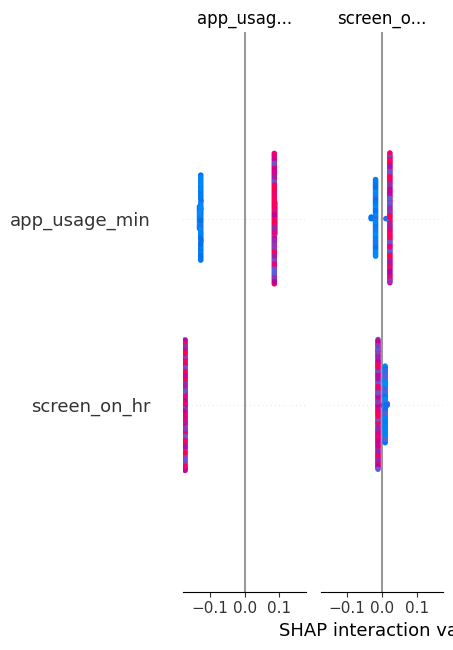

In [42]:
# --------------------------
# 5. SHAP Explainability
# --------------------------
explainer = shap.TreeExplainer(best_model.named_steps['model'])
X_test_scaled = best_model.named_steps['scaler'].transform(X_test) # Scale X_test
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features) # Convert to DataFrame with feature names
shap_values = explainer.shap_values(X_test_scaled_df) # Calculate SHAP values on scaled DataFrame

# Detailed beeswarm plot - Pass the full shap_values list and specify the class
shap.summary_plot(shap_values, X_test_scaled_df, show=False, class_inds=1)
plt.tight_layout()
plt.savefig("churn_shap_beeswarm.png")
plt.show()

Insights from SHAP Beeswarm Plot

The graph visualizes feature interaction effects between app_usage_min (app usage minutes) and screen_on_hr (screen-on hours) on predicting user engagement/churn.

**app_usage_min is a strong driver of engagement:**

Higher app usage minutes (pink dots on the right) push predictions toward higher engagement/retention.

Low usage (blue dots) is associated with lower engagement likelihood.

**Interaction between features matters:**

app_usage_min and screen_on_hr reinforce each other.

Users who spend more time on the app and have longer screen-on times are more likely to stay engaged.

**screen_on_hr alone has modest impact:**

Its predictive power is lower when isolated, but grows when combined with app usage.

**Low-value clusters around zero SHAP values:**


Users with minimal activity do not strongly influence model predictions, making them likely low-engagement or churn-prone users.

Actionable takeaway for PLG strategy:

Focus on increasing meaningful app usage minutes, rather than just screen time.

Identify low-engagement clusters early for re-engagement campaigns.

# Key Insights
1. **Low app usage + low screen time strongly predicts churn.**
2. Heavy users (Behavior Class 4-5) are ~3x more retained.
3. Device type and OS have moderate influence; age & gender minimal.